In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkish-calendar/Turkish calendar.csv
/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv
/kaggle/input/gdz-elektrik-datathon-2023/med.csv
/kaggle/input/gdz-elektrik-datathon-2023/train.csv
/kaggle/input/turkish-calendar-1994-2024/Calendar.csv


# Veri Keşfi 

In [2]:
!pip install pandas_profiling

In [3]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

In [4]:
med = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/med.csv")
train = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/train.csv")
sample_submissioin = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv")

In [5]:
sample_submissioin_profile = ProfileReport(med, title="med")
sample_submissioin_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
med_profile = ProfileReport(med, title="med")
med_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
train_profile = ProfileReport(train, title="train")
train_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Modellemeler ve Görselleştirmelerin Yapılması

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from prophet import Prophet
import os
import warnings
warnings.filterwarnings('ignore')

class cfg():
    
    notebook_name = 'Prophet Baseline'
    data_dir = '/kaggle/input/gdz-elektrik-datathon-2023'
    
    dates = ['Tarih']
    target = 'Dağıtılan Enerji (MWh)'

In [9]:
train = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), 
                  parse_dates=cfg.dates)

In [10]:
med = pd.read_csv(os.path.join(cfg.data_dir, 'med.csv'), 
                  parse_dates=cfg.dates)

In [11]:
sub = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), 
                  parse_dates=cfg.dates)

In [12]:
test = sub.copy()

In [13]:
full_df = pd.concat([
    train,
    test
], axis=0)

In [14]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

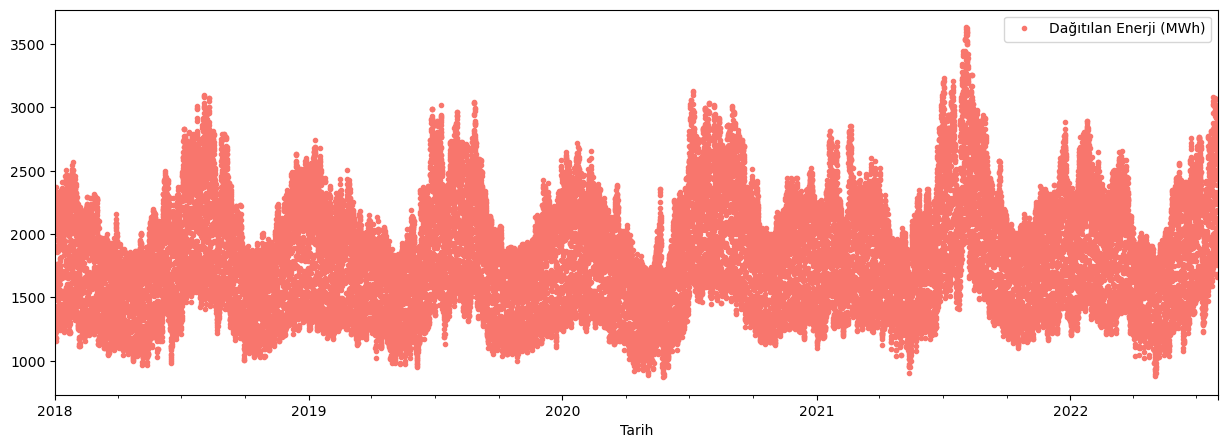

In [15]:
train.set_index(cfg.dates[0]).plot(style='.', figsize=(15,5), color=color_pal[0])
plt.show()

### Bu kod bloğu, veri kümesindeki zaman serisi verilerinin görselleştirilmesini sağlar. 

In [16]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

### Bu fonksiyon, zaman serisi veri setlerinde özellik oluşturmak için kullanılır. Veri setindeki zaman verileri kullanılarak saat, haftanın günü, çeyrek, ay, yıl, yılın günü, ayın günü, yılın haftası gibi özellikler oluşturulur ve X değişkenine atanır. Eğer bir hedef değişken (label) varsa, y değişkenine de atılır ve X ve y değerleri birlikte döndürülür. Eğer label yoksa sadece X döndürülür.

In [17]:
X, y = create_features(train.set_index(cfg.dates[0]), label=cfg.target)

In [18]:
features_and_target = pd.concat([X, y], axis=1)

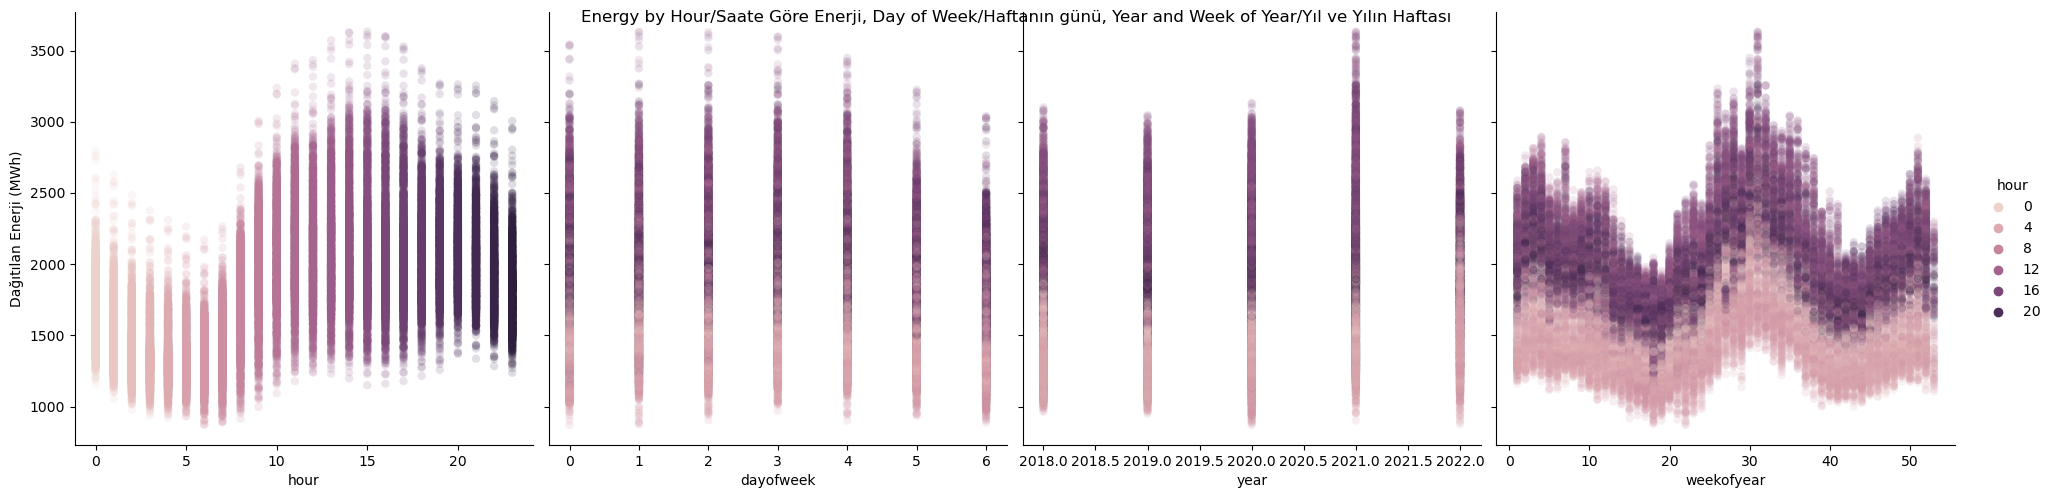

In [19]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars=cfg.target,
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Energy by Hour/Saate Göre Enerji, Day of Week/Haftanın günü, Year and Week of Year/Yıl ve Yılın Haftası')
plt.show()

### Bu kod bloğu, seaborn kütüphanesi kullanılarak çift özellikli bir grafik oluşturur. Özellikleri ve hedef değişkeni içeren bir DataFrame'den başlayarak, grafikteki her bir nokta, x_vars ve y_vars parametreleri arasında ilişkiyi görselleştirir. 'hue' parametresi, her bir saati farklı bir renkte gösterir. Bu sayede saatlere göre enerji tüketimini görebiliriz. "suptitle" komutu, grafik başlığını belirler ve plt.show() komutu, grafikleri görüntüler.

In [20]:
med['isover'] = True
train = pd.merge(train, 
                 med,
                 how='left',
                 on='Tarih')

In [21]:
train = train[train['isover'].isnull()].drop('isover', axis=1)

In [22]:
hol = pd.read_csv('/kaggle/input/turkish-calendar-1994-2024/Calendar.csv', parse_dates=['CALENDAR_DATE'])
hol = hol[['CALENDAR_DATE','RAMADAN_FLAG','PUBLIC_HOLIDAY_FLAG']].rename(columns={'CALENDAR_DATE':'ds'})

In [23]:
hol['holiday'] = np.where((hol['RAMADAN_FLAG'] == 'Y') | (hol['PUBLIC_HOLIDAY_FLAG'] == 'Y'), 'TR-Holidays', 0)
hol = hol[['ds','holiday']]
hol = hol[hol['holiday'] == 'TR-Holidays']

In [24]:
train[cfg.target] = np.log1p(train[cfg.target])

### bir tarih değerindeki ayın Mart, Nisan veya Mayıs aylarından birine denk gelip gelmediğini kontrol ediyor.

In [25]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

### bir tarih değerindeki ayın Haziran, Temmuz veya Ağustos aylarından birine denk gelip gelmediğini kontrol ediyor

In [26]:
def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

### bir tarih değerindeki ayın Eylül, Ekim veya Kasım aylarından birine denk gelip gelmediğini kontrol ediyor

In [27]:
def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

### bir tarih değerindeki ayın Aralık, Ocak veya Şubat aylarından birine denk gelip gelmediğini kontrol ediyor

In [28]:
def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

### bir tarih değerinin hafta sonuna (Cumartesi veya Pazar) denk gelip gelmediğini kontrol ediyor.

In [29]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')

In [30]:
# adding to train set
train['is_spring'] = train['Tarih'].apply(is_spring)
train['is_summer'] = train['Tarih'].apply(is_summer)
train['is_autumn'] = train['Tarih'].apply(is_autumn)
train['is_winter'] = train['Tarih'].apply(is_winter)
train['is_weekend'] = train['Tarih'].apply(is_weekend)
train['is_weekday'] = ~train['Tarih'].apply(is_weekend)

### Bu kod, train adlı bir veri kümesine aşağıdaki sütunları ekler:

* 'is_spring': 'Tarih' sütunundaki tarihin ilkbahar mevsimine (Mart-Nisan-Mayıs) denk gelip gelmediğini gösterir.
* 'is_summer': 'Tarih' sütunundaki tarihin yaz mevsimine (Haziran-Temmuz-Ağustos) denk gelip gelmediğini gösterir.
* 'is_autumn': 'Tarih' sütunundaki tarihin sonbahar mevsimine (Eylül-Ekim-Kasım) denk gelip gelmediğini gösterir.
* 'is_winter': 'Tarih' sütunundaki tarihin kış mevsimine (Aralık-Ocak-Şubat) denk gelip gelmediğini gösterir.
* 'is_weekend': 'Tarih' sütunundaki tarihin hafta sonuna (Cumartesi veya Pazar) denk gelip gelmediğini gösterir.
* 'is_weekday': 'is_weekend' sütununun tersidir ve 'Tarih' sütunundaki tarihin hafta içine (Pazartesi'den Cuma'ya kadar) denk gelip gelmediğini gösterir.
### Her bir sütun, apply() yöntemiyle, ilgili mevsim/harici faktör fonksiyonuna uygulanarak hesaplanır ve sonuçlar sütunlara kaydedilir.

In [31]:
# adding to test set
test['is_spring'] = test['Tarih'].apply(is_spring)
test['is_summer'] = test['Tarih'].apply(is_summer)
test['is_autumn'] = test['Tarih'].apply(is_autumn)
test['is_winter'] = test['Tarih'].apply(is_winter)
test['is_weekend'] = test['Tarih'].apply(is_weekend)
test['is_weekday'] = ~test['Tarih'].apply(is_weekend)

### Bu kod, test adlı bir veri kümesine aynı sütunları ekler:

* 'is_spring': 'Tarih' sütunundaki tarihin ilkbahar mevsimine (Mart-Nisan-Mayıs) denk gelip gelmediğini gösterir.
* 'is_summer': 'Tarih' sütunundaki tarihin yaz mevsimine (Haziran-Temmuz-Ağustos) denk gelip gelmediğini gösterir.
* 'is_autumn': 'Tarih' sütunundaki tarihin sonbahar mevsimine (Eylül-Ekim-Kasım) denk gelip gelmediğini gösterir.
* 'is_winter': 'Tarih' sütunundaki tarihin kış mevsimine (Aralık-Ocak-Şubat) denk gelip gelmediğini gösterir.
* 'is_weekend': 'Tarih' sütunundaki tarihin hafta sonuna (Cumartesi veya Pazar) denk gelip gelmediğini gösterir.
* 'is_weekday': 'is_weekend' sütununun tersidir ve 'Tarih' sütunundaki tarihin hafta içine (Pazartesi'den Cuma'ya kadar) denk gelip gelmediğini gösterir.

### Her bir sütun, apply() yöntemiyle, ilgili mevsim/harici faktör fonksiyonuna uygulanarak hesaplanır ve sonuçlar sütunlara kaydedilir.

### add_seasonality() yöntemi, Prophet modeline yeni bir döngüsel bileşen eklemek için kullanılır. Bu yöntem, bileşenin adını belirten bir dize, periyodu belirten bir sayı, Fourier derecesini belirten bir sayı ve bileşenin nasıl hesaplanacağını belirten bir koşul adı içeren bir dizi parametre alır.

In [32]:
model = Prophet(holidays=hol)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

In [33]:
model.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')

In [34]:
model.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')

In [35]:
model.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')

In [36]:
model.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')

In [37]:
model.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')

In [38]:
model.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')

In [39]:
model.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')

In [40]:
model.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')

In [41]:
model.add_seasonality(name='daily_weekend',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekend')

In [42]:
model.add_seasonality(name='daily_weekday',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekday')

In [43]:
model.fit(train.rename(columns={'Tarih':'ds',
                                cfg.target:'y'}))

18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing


### Bu kod, eğitim verilerinin Prophet modeline uygun formatta verilmesi ve modelin bu verileri öğrenmesi için kullanılır. fit() yöntemi, Prophet modelinin eğitim verilerine uygun şekilde ayarlanmasını ve eğitilmesini sağlar.

### Burada, train veri kümesi, "Tarih" sütununun adı "ds" olarak değiştirildikten sonra fit() yöntemine geçirilir. Ayrıca hedef değişkenin adı da cfg.target ile belirtilen adla "y" olarak değiştirilir. Bu, verilerin Prophet modeli için doğru formatta olmasını sağlar.

### Model, fit() yöntemi çağrıldığında eğitilir ve eğitim verilerindeki zaman serisini ve diğer özellikleri analiz ederek gelecekteki değerleri tahmin edebilecek şekilde ayarlanır.

In [44]:
test_preds = model.predict(df=test.rename(columns={'Tarih':'ds',
                                                   cfg.target:'y'}))
test_preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,TR-Holidays,TR-Holidays_lower,TR-Holidays_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,daily_autumn,daily_autumn_lower,daily_autumn_upper,daily_spring,daily_spring_lower,daily_spring_upper,daily_summer,daily_summer_lower,daily_summer_upper,daily_weekday,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,weekly_autumn,weekly_autumn_lower,weekly_autumn_upper,weekly_spring,weekly_spring_lower,weekly_spring_upper,weekly_summer,weekly_summer_lower,weekly_summer_upper,weekly_winter,weekly_winter_lower,weekly_winter_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-01 00:00:00,7.52175,7.49989,7.70169,7.52175,7.52175,0.00000,0.00000,0.00000,0.07606,0.07606,0.07606,-0.04003,-0.04003,-0.04003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00088,0.00088,0.00088,-0.03169,...,0.00000,0.00000,0.00000,-0.04975,-0.04975,-0.04975,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.01322,-0.01322,-0.01322,0.00000,0.00000,0.00000,0.20988,0.20988,0.20988,0.00000,0.00000,0.00000,7.59782
1,2022-08-01 01:00:00,7.52175,7.42192,7.61168,7.52175,7.52175,0.00000,0.00000,0.00000,-0.00013,-0.00013,-0.00013,-0.07484,-0.07484,-0.07484,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00199,-0.00199,-0.00199,-0.07816,...,0.00000,0.00000,0.00000,-0.04617,-0.04617,-0.04617,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00894,-0.00894,-0.00894,0.00000,0.00000,0.00000,0.20997,0.20997,0.20997,0.00000,0.00000,0.00000,7.52162
2,2022-08-01 02:00:00,7.52174,7.37088,7.57405,7.52174,7.52174,0.00000,0.00000,0.00000,-0.04876,-0.04876,-0.04876,-0.10146,-0.10146,-0.10146,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00127,0.00127,0.00127,-0.11151,...,0.00000,0.00000,0.00000,-0.04243,-0.04243,-0.04243,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00468,-0.00468,-0.00468,0.00000,0.00000,0.00000,0.21005,0.21005,0.21005,0.00000,0.00000,0.00000,7.47299
3,2022-08-01 03:00:00,7.52174,7.34999,7.54182,7.52174,7.52174,0.00000,0.00000,0.00000,-0.07355,-0.07355,-0.07355,-0.12155,-0.12155,-0.12155,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00044,0.00044,0.00044,-0.12344,...,0.00000,0.00000,0.00000,-0.03856,-0.03856,-0.03856,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00058,-0.00058,-0.00058,0.00000,0.00000,0.00000,0.21014,0.21014,0.21014,0.00000,0.00000,0.00000,7.44819
4,2022-08-01 04:00:00,7.52174,7.32002,7.51884,7.52174,7.52174,0.00000,0.00000,0.00000,-0.09840,-0.09840,-0.09840,-0.13551,-0.13551,-0.13551,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.01535,-0.01535,-0.01535,-0.12643,...,0.00000,0.00000,0.00000,-0.03461,-0.03461,-0.03461,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00328,0.00328,0.00328,0.00000,0.00000,0.00000,0.21022,0.21022,0.21022,0.00000,0.00000,0.00000,7.42333


### Bu kod, Prophet modeli tarafından eğitilen bir zaman serisi modeli kullanarak, test veri kümesindeki zaman serisi değerlerine dayalı tahminler yapmak için kullanılır.

### predict() yöntemi, test verilerinin Prophet modeli için uygun hale getirilmesi ve sonuçların tahmin edilmesi için kullanılır. Burada, test veri kümesi, "Tarih" sütununun adı "ds" olarak değiştirildikten sonra predict() yöntemine geçirilir. Ayrıca, hedef değişkenin adı da cfg.target ile belirtilen adla "y" olarak değiştirilir. Bu, verilerin Prophet modeli için doğru formatta olmasını sağlar.

### Sonuç olarak, test_preds adlı bir DataFrame nesnesi oluşturulur. Bu nesne, test veri kümesindeki her bir girdi için bir tahmin değeri içerir. Bu değerler, model tarafından öğrenilen trend, mevsimsellik ve diğer özelliklerin bir kombinasyonuna dayanarak tahmin edilir.

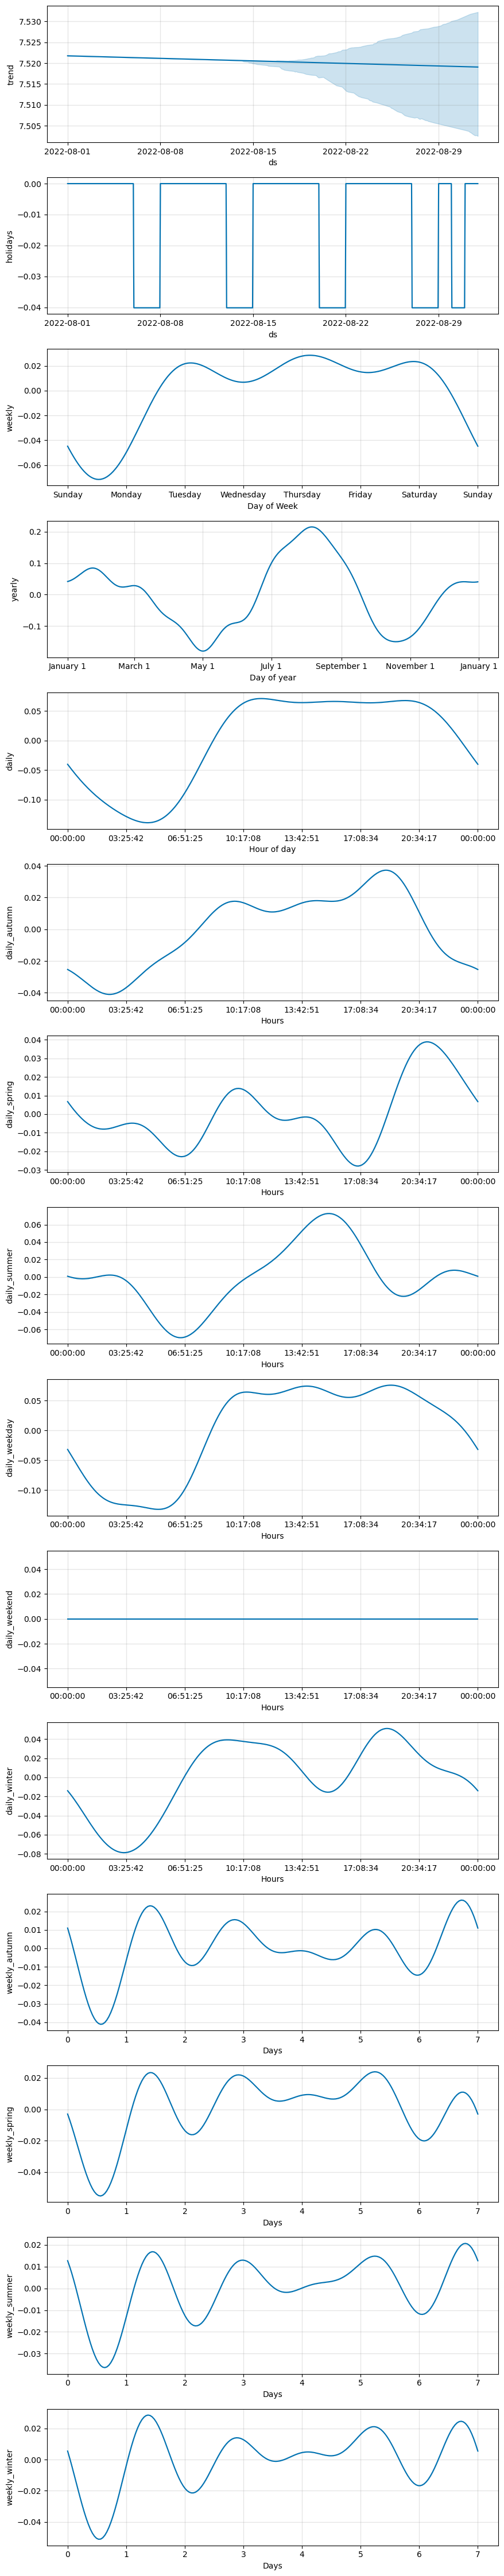

In [45]:
fig = model.plot_components(test_preds)

### Bu kod, Prophet modeli tarafından öğrenilen mevsimsellik, trend ve diğer zaman serisi bileşenlerinin görselleştirilmesi için kullanılır.

### plot_components() yöntemi, verilerin mevsimsellik, trend ve haftalık yapıları gibi farklı özelliklerini görselleştirmek için kullanılır. Burada, test_preds parametresi, modelin test veri kümesi üzerindeki tahminlerini içeren DataFrame nesnesini içerir.

### Bu yöntem, bir matplotlib grafiği oluşturur ve yukarıda belirtilen bileşenleri ayrı ayrı gösteren alt grafikler içerir. Bu grafiği kullanarak, verilerdeki belirli mevsimsellik, trend veya haftalık yapılar hakkında bilgi edinebilir ve bu bilgiyi modelin sonuçlarını anlamak için kullanabilirsiniz.

In [46]:
test_preds['yhat'] = np.expm1(test_preds['yhat'])

### Bu kod, test_preds veri kümesindeki tahmin edilen değerleri gerçek veri ölçeğine dönüştürmek için kullanılır. yhat sütunu, modelin tahmin ettiği hedef değişkenin değerlerini içerir. np.expm1() fonksiyonu, verilen değerin doğal logaritmasını alarak ve ardından 1 azaltarak gerçek değere dönüştürür.

In [47]:
tahmin1 = test_preds['yhat'].values

### Bu kod, Prophet modelinden tahmin edilen hedef değişken değerlerini içeren yhat sütununu test_preds veri kümesinden ayıklar ve bu değerleri tahmin1 adlı bir NumPy dizisine atar. Bu işlem, modelin tahminlerini daha sonra analiz etmek veya başka bir amaçla kullanmak için gereklidir.

In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [49]:
train_df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv')
submit_df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv')
med_df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv')

In [50]:
med_df["Yıl"] = pd.to_datetime(med_df["Tarih"]).dt.year
med_df["Ay"] = pd.to_datetime(med_df["Tarih"]).dt.month
med_df["Gün"] = pd.to_datetime(med_df["Tarih"]).dt.day

In [51]:
train_df["Yıl"] = pd.to_datetime(train_df["Tarih"]).dt.year
train_df["Ay"] = pd.to_datetime(train_df["Tarih"]).dt.month
train_df["Gün"] = pd.to_datetime(train_df["Tarih"]).dt.day
train_df["Saat"] = pd.to_datetime(train_df["Tarih"]).dt.hour

In [52]:
submit_df["Yıl"] = pd.to_datetime(submit_df["Tarih"]).dt.year
submit_df["Ay"] = pd.to_datetime(submit_df["Tarih"]).dt.month
submit_df["Gün"] = pd.to_datetime(submit_df["Tarih"]).dt.day
submit_df["Saat"] = pd.to_datetime(submit_df["Tarih"]).dt.hour
submit_df["Kesintili Günler"]=0

In [53]:
train_df = train_df.drop("Tarih", axis=1)
submit_df = submit_df.drop("Tarih", axis=1)
med_df = med_df.drop("Tarih", axis=1)

### Bu kodlar, train_df, submit_df ve med_df veri kümelerindeki "Tarih" sütununu çıkarır. drop() fonksiyonu, belirtilen sütunu veri kümesinden çıkarmak için kullanılır ve axis=1 argümanı sütunlar üzerinde işlem yapılacağını belirtir. Bu işlem sonrasında veri kümeleri "Tarih" sütunundan arındırılmış olur ve sadece modelin tahmin yapmak için kullanacağı özellikleri içerir.

In [54]:
med_df[['Yıl', 'Ay', 'Gün']] = med_df[['Yıl', 'Ay', 'Gün']].astype(int)
train_df['Kesintili Günler'] = train_df.apply(lambda row: int((row[['Yıl', 'Ay', 'Gün']] == med_df[['Yıl', 'Ay', 'Gün']]).all(axis=1).any()), axis=1)

### train_df'deki 'Yıl', 'Ay', 'Gün' sütunları int tipine çevrildi ve med_df ile birleştirildi. Daha sonra 'Kesintili Günler' sütunu train_df'e eklendi. Bu sütun, med_df'de yer alan tarihlerin train_df'de var olup olmadığını kontrol eder ve eğer varsa 1, yoksa 0 değerini alır.

In [55]:
calendar = pd.read_csv("/kaggle/input/turkish-calendar/Turkish calendar.csv",sep=(";"))

In [56]:
new_df = calendar.iloc[853:2557].copy()

In [57]:
new_df.loc[:, "Ay"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.month
new_df.loc[:, "Yıl"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.year

In [58]:
new_df = new_df.drop(["SEASON_SK", "SPECIAL_DAY_SK", "SPECIAL_DAY_SK2"], axis=1)

In [59]:
new_df["WEEKEND_FLAG"] =new_df["WEEKEND_FLAG"].replace(["N"],0)
new_df["WEEKEND_FLAG"] =new_df["WEEKEND_FLAG"].replace(["Y"],1)

In [60]:
new_df["RAMADAN_FLAG"] =new_df["RAMADAN_FLAG"].replace(["N"],0)
new_df["RAMADAN_FLAG"] =new_df["RAMADAN_FLAG"].replace(["Y"],1)

In [61]:
new_df["PUBLIC_HOLIDAY_FLAG"] =new_df["PUBLIC_HOLIDAY_FLAG"].replace(["N"],0)
new_df["PUBLIC_HOLIDAY_FLAG"] =new_df["PUBLIC_HOLIDAY_FLAG"].replace(["Y"],1)

In [62]:
new_df.rename(columns={'DAY_OF_MONTH': 'Gün'}, inplace=True)
new_df.rename(columns={'DAY_OF_WEEK_SK': 'Haftanın Günü'}, inplace=True)
new_df.rename(columns={'QUARTER_OF_YEAR': 'Sezon'}, inplace=True)
new_df.rename(columns={'WEEKEND_FLAG': 'Haftasonu - Haftaiçi'}, inplace=True)
new_df.rename(columns={'WEEK_OF_YEAR': 'Yılın kaçıncı haftası'}, inplace=True)
new_df.rename(columns={'RAMADAN_FLAG': 'Ramazan'}, inplace=True)
new_df.rename(columns={'RELIGIOUS_DAY_FLAG_SK': 'Dini Gün'}, inplace=True)
new_df.rename(columns={'NATIONAL_DAY_FLAG_SK': 'Ulusal Gün'}, inplace=True)
new_df.rename(columns={'PUBLIC_HOLIDAY_FLAG': 'Resmi tatil'}, inplace=True)

In [63]:
new_df_submit=new_df.iloc[0:31]
new_df_train=new_df.iloc[31:1704]

In [64]:
merged_df = pd.merge(train_df, new_df_train, on=["Yıl", "Ay", "Gün"])
merged_df2 = pd.merge(submit_df, new_df_submit, on=["Yıl", "Ay", "Gün"])

In [65]:
X_train=merged_df.drop("Dağıtılan Enerji (MWh)", axis=1)
X_train=X_train.drop("CALENDAR_DATE", axis=1)

### Bu kodlar, merged_df veri kümesinden "Dağıtılan Enerji (MWh)" ve "CALENDAR_DATE" sütunlarını çıkararak, yalnızca modelin eğitiminde kullanılacak özellikleri içeren X_train veri kümesini oluşturur. drop() fonksiyonu, belirtilen sütunları veri kümesinden çıkarmak için kullanılır ve axis=1 argümanı sütunlar üzerinde işlem yapılacağını belirtir.

In [66]:
y_train=merged_df["Dağıtılan Enerji (MWh)"]

In [67]:
X_test=merged_df2.drop("Dağıtılan Enerji (MWh)", axis=1)
X_test=X_test.drop("CALENDAR_DATE", axis=1)

### Bu kodlar, merged_df2 veri kümesinden "Dağıtılan Enerji (MWh)" ve "CALENDAR_DATE" sütunlarını çıkararak, yalnızca modelin tahmin yapmak için kullanacağı özellikleri içeren X_test veri kümesini oluşturur. drop() fonksiyonu, belirtilen sütunları veri kümesinden çıkarmak için kullanılır ve axis=1 argümanı sütunlar üzerinde işlem yapılacağını belirtir.

In [68]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [69]:
tahmin2 = rf_model.predict(X_test)

### Bu kod, X_test veri kümesindeki özellikleri kullanarak rastgele orman modeli (rf_model) ile bir tahmin yapar ve sonucu tahmin2 değişkenine atar.

In [70]:
y_pred= tahmin1*0.6+tahmin2*0.4

### Bu satır, iki farklı modelden gelen tahminlerin birleştirilmesini sağlıyor. İlk tahminin ağırlığı %60, ikinci tahminin ağırlığı %40 olarak belirlenmiş ve bu ağırlıklar kullanılarak iki tahminin ağırlıklı ortalaması alınmıştır. Elde edilen sonuç, birleştirilen iki modelin tahminlerinin bir karışımıdır.

In [71]:
subm= pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv')
subm["Dağıtılan Enerji (MWh)"]=y_pred
subm

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,2138.99235
1,2022-08-01 01:00:00,2007.99290
2,2022-08-01 02:00:00,1985.47887
3,2022-08-01 03:00:00,1928.07201
4,2022-08-01 04:00:00,1874.57703
...,...,...
739,2022-08-31 19:00:00,2513.67902
740,2022-08-31 20:00:00,2496.16683
741,2022-08-31 21:00:00,2459.80112
742,2022-08-31 22:00:00,2355.74419


In [72]:
subm.to_csv("submissionserkan.csv",index=None)

### Bu kod, "subm" isimli veri çerçevesindeki tahminleri içeren bir CSV dosyası oluşturur ve bu dosyayı "submissionserkan.csv" adıyla kaydeder. "index=None" ifadesi, satır indekslerinin dosyaya dahil edilmemesini sağlar.

# 2.Model

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from prophet import Prophet
import os
import warnings
warnings.filterwarnings('ignore')

class cfg():
    
    notebook_name = 'Prophet Baseline'
    data_dir = '/kaggle/input/gdz-elektrik-datathon-2023'
    
    dates = ['Tarih']
    target = 'Dağıtılan Enerji (MWh)'

In [74]:
train = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), 
                  parse_dates=cfg.dates)

In [75]:
med = pd.read_csv(os.path.join(cfg.data_dir, 'med.csv'), 
                  parse_dates=cfg.dates)

In [76]:
sub = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), 
                  parse_dates=cfg.dates)

In [77]:
test = sub.copy()

In [78]:
full_df = pd.concat([
    train,
    test
], axis=0)

In [79]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [80]:
X, y = create_features(train.set_index(cfg.dates[0]), label=cfg.target)

features_and_target = pd.concat([X, y], axis=1)

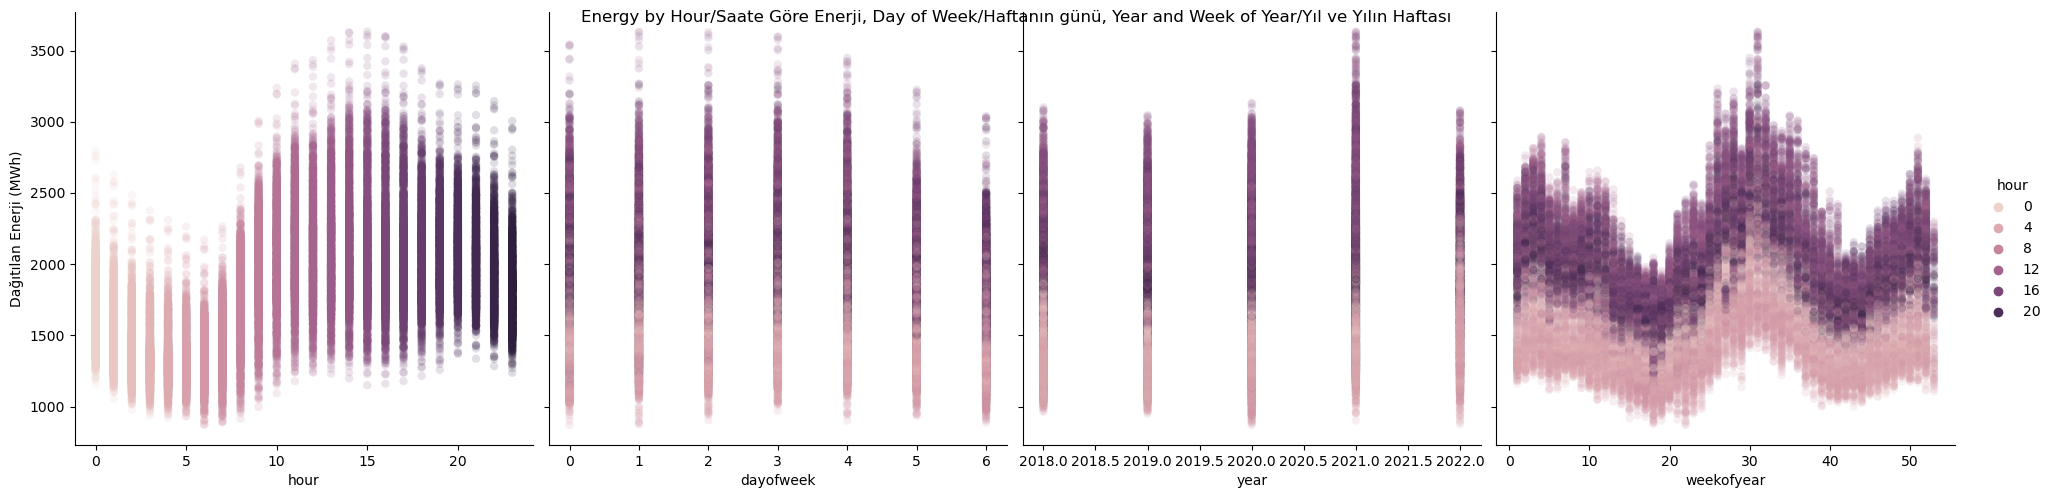

In [81]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars=cfg.target,
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Energy by Hour/Saate Göre Enerji, Day of Week/Haftanın günü, Year and Week of Year/Yıl ve Yılın Haftası')
plt.show()

In [82]:
med['isover'] = True
train = pd.merge(train, 
                 med,
                 how='left',
                 on='Tarih')

In [83]:
train = train[train['isover'].isnull()].drop('isover', axis=1)

In [84]:
hol = pd.read_csv('/kaggle/input/turkish-calendar-1994-2024/Calendar.csv', parse_dates=['CALENDAR_DATE'])
hol = hol[['CALENDAR_DATE','RAMADAN_FLAG','PUBLIC_HOLIDAY_FLAG']].rename(columns={'CALENDAR_DATE':'ds'})
hol['holiday'] = np.where((hol['RAMADAN_FLAG'] == 'Y') | (hol['PUBLIC_HOLIDAY_FLAG'] == 'Y'), 'TR-Holidays', 0)
hol = hol[['ds','holiday']]
hol = hol[hol['holiday'] == 'TR-Holidays']

In [85]:
train[cfg.target] = np.log1p(train[cfg.target])

In [86]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

In [87]:
def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

In [88]:
def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

In [89]:
def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

In [90]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')

In [91]:
# adding to train set
train['is_spring'] = train['Tarih'].apply(is_spring)
train['is_summer'] = train['Tarih'].apply(is_summer)
train['is_autumn'] = train['Tarih'].apply(is_autumn)
train['is_winter'] = train['Tarih'].apply(is_winter)
train['is_weekend'] = train['Tarih'].apply(is_weekend)
train['is_weekday'] = ~train['Tarih'].apply(is_weekend)

In [92]:
# adding to test set
test['is_spring'] = test['Tarih'].apply(is_spring)
test['is_summer'] = test['Tarih'].apply(is_summer)
test['is_autumn'] = test['Tarih'].apply(is_autumn)
test['is_winter'] = test['Tarih'].apply(is_winter)
test['is_weekend'] = test['Tarih'].apply(is_weekend)
test['is_weekday'] = ~test['Tarih'].apply(is_weekend)

In [93]:
model = Prophet(holidays=hol)

In [94]:
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')

In [95]:
model.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')

In [96]:
model.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')

In [97]:
model.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')

In [98]:
model.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')

In [99]:
model.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')

In [100]:
model.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')

In [101]:
model.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')

In [102]:
model.add_seasonality(name='daily_weekend',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekend')

In [103]:
model.add_seasonality(name='daily_weekday',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekday')

In [104]:
model.fit(train.rename(columns={'Tarih':'ds',
                                cfg.target:'y'}))

18:56:55 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing


In [105]:
test_preds = model.predict(df=test.rename(columns={'Tarih':'ds',
                                                   cfg.target:'y'}))

In [106]:
test_preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,TR-Holidays,TR-Holidays_lower,TR-Holidays_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,daily_autumn,daily_autumn_lower,daily_autumn_upper,daily_spring,daily_spring_lower,daily_spring_upper,daily_summer,daily_summer_lower,daily_summer_upper,daily_weekday,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,weekly_autumn,weekly_autumn_lower,weekly_autumn_upper,weekly_spring,weekly_spring_lower,weekly_spring_upper,weekly_summer,weekly_summer_lower,weekly_summer_upper,weekly_winter,weekly_winter_lower,weekly_winter_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-01 00:00:00,7.52175,7.50181,7.69007,7.52175,7.52175,0.00000,0.00000,0.00000,0.07606,0.07606,0.07606,-0.04003,-0.04003,-0.04003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00088,0.00088,0.00088,-0.03169,...,0.00000,0.00000,0.00000,-0.04975,-0.04975,-0.04975,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.01322,-0.01322,-0.01322,0.00000,0.00000,0.00000,0.20988,0.20988,0.20988,0.00000,0.00000,0.00000,7.59782
1,2022-08-01 01:00:00,7.52175,7.42475,7.62574,7.52175,7.52175,0.00000,0.00000,0.00000,-0.00013,-0.00013,-0.00013,-0.07484,-0.07484,-0.07484,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00199,-0.00199,-0.00199,-0.07816,...,0.00000,0.00000,0.00000,-0.04617,-0.04617,-0.04617,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00894,-0.00894,-0.00894,0.00000,0.00000,0.00000,0.20997,0.20997,0.20997,0.00000,0.00000,0.00000,7.52162
2,2022-08-01 02:00:00,7.52174,7.37543,7.57377,7.52174,7.52174,0.00000,0.00000,0.00000,-0.04876,-0.04876,-0.04876,-0.10146,-0.10146,-0.10146,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00127,0.00127,0.00127,-0.11151,...,0.00000,0.00000,0.00000,-0.04243,-0.04243,-0.04243,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00468,-0.00468,-0.00468,0.00000,0.00000,0.00000,0.21005,0.21005,0.21005,0.00000,0.00000,0.00000,7.47299
3,2022-08-01 03:00:00,7.52174,7.35493,7.54781,7.52174,7.52174,0.00000,0.00000,0.00000,-0.07355,-0.07355,-0.07355,-0.12155,-0.12155,-0.12155,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00044,0.00044,0.00044,-0.12344,...,0.00000,0.00000,0.00000,-0.03856,-0.03856,-0.03856,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00058,-0.00058,-0.00058,0.00000,0.00000,0.00000,0.21014,0.21014,0.21014,0.00000,0.00000,0.00000,7.44819
4,2022-08-01 04:00:00,7.52174,7.32362,7.51988,7.52174,7.52174,0.00000,0.00000,0.00000,-0.09840,-0.09840,-0.09840,-0.13551,-0.13551,-0.13551,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.01535,-0.01535,-0.01535,-0.12643,...,0.00000,0.00000,0.00000,-0.03461,-0.03461,-0.03461,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00328,0.00328,0.00328,0.00000,0.00000,0.00000,0.21022,0.21022,0.21022,0.00000,0.00000,0.00000,7.42333


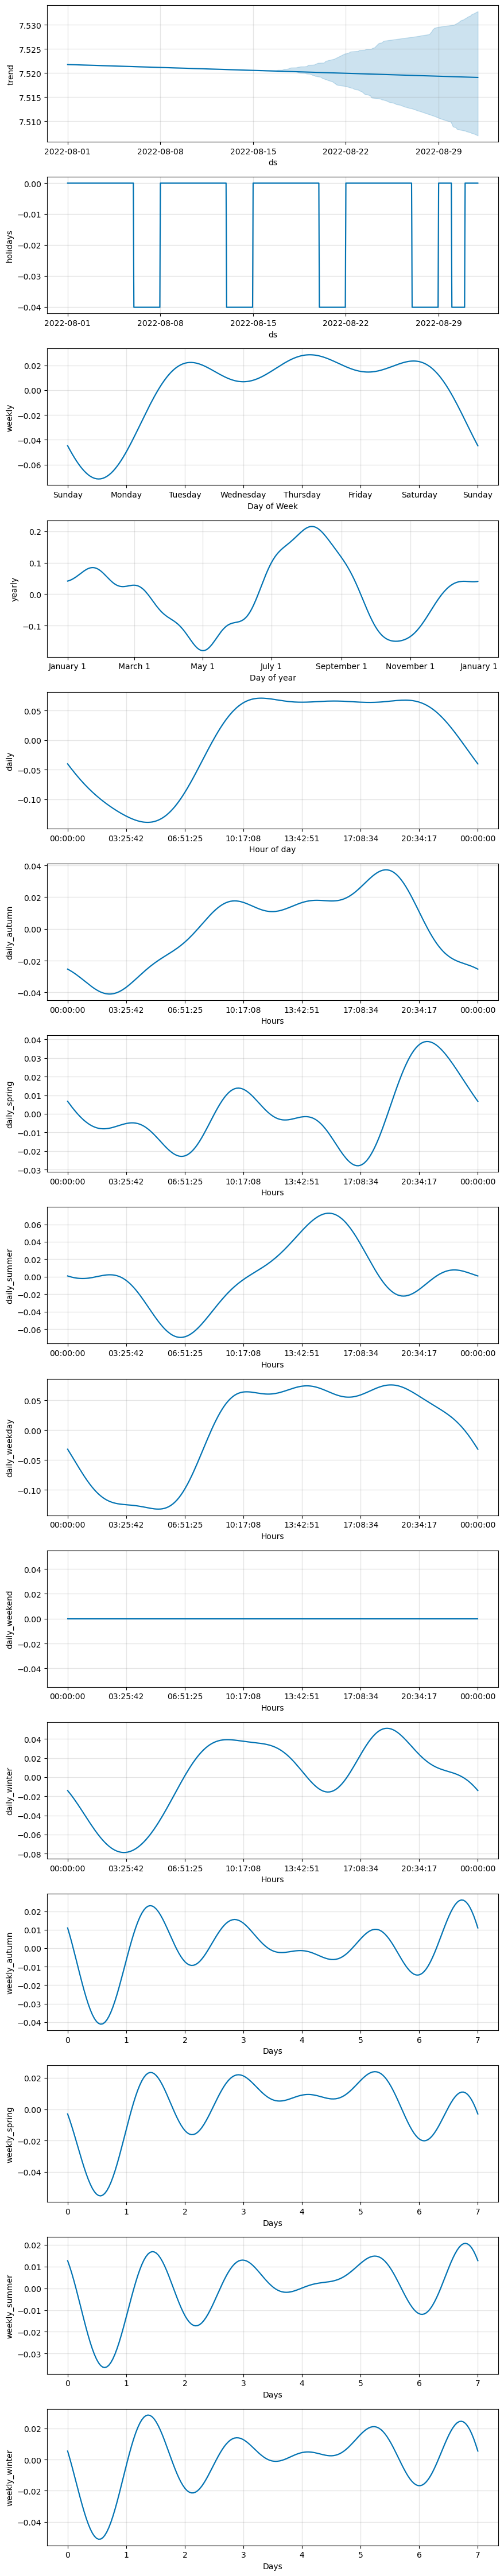

In [107]:
fig = model.plot_components(test_preds)

In [108]:
test_preds['yhat'] = np.expm1(test_preds['yhat'])

In [109]:
sub[cfg.target] = test_preds['yhat'].values
sub.to_csv(cfg.notebook_name+'_PROPHET.csv', index=False)
sub[:20]

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,1992.83648
1,2022-08-01 01:00:00,1846.55693
2,2022-08-01 02:00:00,1758.85662
3,2022-08-01 03:00:00,1715.74822
4,2022-08-01 04:00:00,1673.60581
5,2022-08-01 05:00:00,1628.29124
6,2022-08-01 06:00:00,1639.19151
7,2022-08-01 07:00:00,1774.58737
8,2022-08-01 08:00:00,2043.12151
9,2022-08-01 09:00:00,2353.48588
